Evolving in time: 100%|██████████| 400000/400000 [12:38:20<00:00,  8.79it/s]        


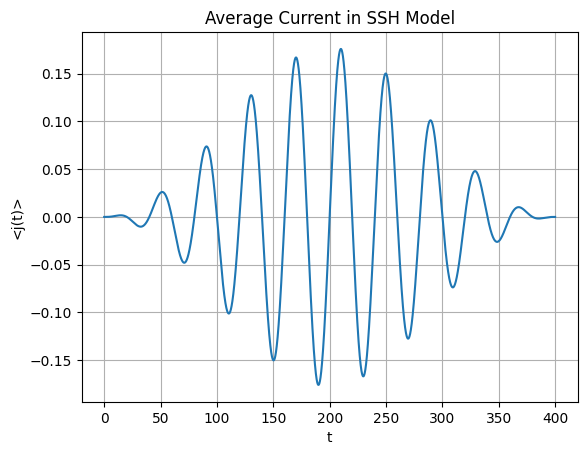

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
t1, t2 = 2.0, 1.0
A0 = 0.5
Nc = 10
omega0 = np.pi / (2 * Nc)
dt = 0.001
Nk = 251
dk = 2 * np.pi / Nk
k_values = np.linspace(-np.pi, np.pi, Nk, endpoint=False)

T = 2 * np.pi * Nc / omega0
Nt = int(T / dt)

# Initial density matrix (same for each k)
rho0 = np.array([[0, 0],
                 [0, 1]], dtype=complex)
rho_k = np.tile(rho0, (Nk, 1, 1))

# Field
def A_t(t):
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

# Hamiltonian in eigenbasis (analytic form)
def H_elements(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    #EQUATION 11 & 12
    Hpm = 1j*t2*(t2*np.sin(At) + t1*(np.sin(k) - np.sin(k - At))) / denom
    Hmp = -np.conj(Hpm)  # Fixed: use conjugate
    return np.array([[Hpp, Hpm],
                     [Hmp, Hmm]], dtype=complex)

# Current operator (analytic derivatives)
def current_operator(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    
    # Diagonal elements derivatives
    # dHpp/dk = -t1*t2*np.sin(k)/denom
    dHpp = -t1*t2*np.sin(k)/denom
    dHmm = -dHpp
    
    # Off-diagonal elements derivatives  
    # dHpm/dk = 1j*t1*t2*np.cos(k)/denom
    dHpm = 1j*t1*t2*np.cos(k)/denom
    dHmp = -np.conj(dHpm)  # Fixed: use conjugate
    
    return np.array([[dHpp, dHpm],
                     [dHmp, dHmm]], dtype=complex)

# Commutator
def commutator(A, B):
    return A @ B - B @ A

# Time evolution
avg_current = []

for n in tqdm(range(Nt), desc="Evolving in time"):
    t = n * dt
    At = A_t(t)
    j_total = 0.0

    # Vectorized over k
    for i, k in enumerate(k_values):
        H = H_elements(k, At)
        drho = -1j * commutator(H, rho_k[i])
        rho_k[i] += dt * drho

        J = current_operator(k, At)
        j_total += np.trace(J @ rho_k[i]).real * dk / (2*np.pi)

    avg_current.append(j_total)

# Plot
time = np.linspace(0, T, Nt)
plt.plot(time, avg_current)
plt.xlabel("t")
plt.ylabel("<j(t)>")
plt.title("Average Current in SSH Model")
plt.grid(True)
plt.show()

Evolving in time: 100%|██████████| 400000/400000 [3:47:21<00:00, 29.32it/s]     


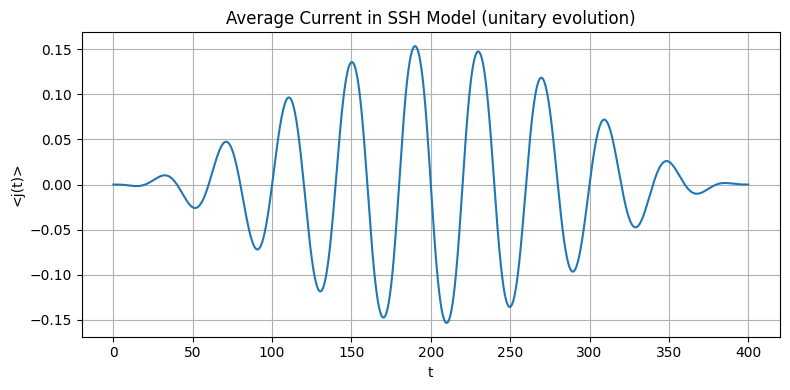

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as sla

# Parameters
t1, t2 = 2.0, 1.0
A0 = 0.5
Nc = 10
omega0 = np.pi / (2 * Nc)
dt = 0.001
Nk = 251
dk = 2 * np.pi / Nk
k_values = np.linspace(-np.pi, np.pi, Nk, endpoint=False)

T = 2 * np.pi * Nc / omega0
Nt = int(np.round(T / dt))

# Initial density matrix (same for each k) -- occupation of lower band
rho0 = np.array([[0, 0],
                 [0, 1]], dtype=complex)
rho_k = np.tile(rho0, (Nk, 1, 1)).astype(complex)

# Field
def A_t(t):
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

# Hamiltonian in eigenbasis (analytic form)
def H_elements(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    # off-diagonal element (complex). Ensure Hermiticity Hmp = conj(Hpm)
    Hpm = 1j * t2 * (t2 * np.sin(At) + t1 * (np.sin(k) - np.sin(k - At))) / denom
    Hmp = np.conj(Hpm)
    return np.array([[Hpp, Hpm],
                     [Hmp, Hmm]], dtype=complex)

# Current operator (analytic derivatives) — check if At affects these derivatives in your model
def current_operator(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    dHpp = -t1 * t2 * np.sin(k) / denom
    dHmm = -dHpp
    dHpm = 1j * t1 * t2 * np.cos(k) / denom
    dHmp = np.conj(dHpm)
    return np.array([[dHpp, dHpm],
                     [dHmp, dHmm]], dtype=complex)

# Commutator (kept for clarity; not used for evolution with U)
def commutator(A, B):
    return A @ B - B @ A

# Time evolution using unitary propagator via eigen decomposition
avg_current = []

for n in tqdm(range(Nt), desc="Evolving in time"):
    t = n * dt
    At = A_t(t)
    j_total = 0.0

    for i, k in enumerate(k_values):
        H = H_elements(k, At)

        # Diagonalize H (Hermitian) and build U = V diag(exp(-i E dt)) V^dagger
        # This is faster / more stable than computing expm(H) every step.
        evals, evecs = np.linalg.eigh(H)
        U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T

        # Propagate density matrix unitarily: rho -> U rho U^\dagger
        rho_k[i] = U @ rho_k[i] @ U.conj().T

        # compute current expectation
        J = current_operator(k, At)
        j_total += np.trace(J @ rho_k[i]).real * dk / (2*np.pi)

    avg_current.append(j_total)

# Plot
time = np.linspace(0, T, Nt)
plt.figure(figsize=(8,4))
plt.plot(time, avg_current)
plt.xlabel("t")
plt.ylabel("<j(t)>")
plt.title("Average Current in SSH Model (unitary evolution)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
t1, t2 = 1.0, 2.0
A0 = 0.5
Nc = 10
omega0 = np.pi / (2 * Nc)
dt = 0.001
Nk = 251
dk = 2 * np.pi / Nk
k_values = np.linspace(-np.pi, np.pi, Nk, endpoint=False)

T = 2 * np.pi * Nc / omega0
Nt = int(T / dt)

# Initial density matrix (same for each k)
rho0 = np.array([[0, 0],
                 [0, 1]], dtype=complex)
rho_k = np.tile(rho0, (Nk, 1, 1))

# Field
def A_t(t):
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

# Hamiltonian in eigenbasis (analytic form)
def H_elements(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    Hpm = 1j*t2*(t2*np.sin(At) + t1*(np.sin(k) - np.sin(k - At))) / denom
    Hmp = -np.conj(Hpm)  # Fixed: use conjugate
    return np.array([[Hpp, Hpm],
                     [Hmp, Hmm]], dtype=complex)

# Current operator (analytic derivatives)
def current_operator(k, At):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    
    # Diagonal elements derivatives
    # dHpp/dk = -t1*t2*np.sin(k)/denom
    dHpp = -t1*t2*np.sin(k)/denom
    dHmm = -dHpp
    
    # Off-diagonal elements derivatives  
    # dHpm/dk = 1j*t1*t2*np.cos(k)/denom
    dHpm = 1j*t1*t2*np.cos(k)/denom
    dHmp = -np.conj(dHpm)  # Fixed: use conjugate
    
    return np.array([[dHpp, dHpm],
                     [dHmp, dHmm]], dtype=complex)

# Commutator
def commutator(A, B):
    return A @ B - B @ A

# Time evolution
avg_current = []

for n in tqdm(range(Nt), desc="Evolving in time"):
    t = n * dt
    At = A_t(t)
    j_total = 0.0

    # Vectorized over k
    for i, k in enumerate(k_values):
        H = H_elements(k, At)
        drho = -1j * commutator(H, rho_k[i])
        rho_k[i] += dt * drho

        J = current_operator(k, At)
        j_total += np.trace(J @ rho_k[i]).real * dk / (2*np.pi)

    avg_current.append(j_total)

# Plot
time = np.linspace(0, T, Nt)
plt.plot(time, avg_current)
plt.xlabel("t")
plt.ylabel("<j(t)>")
plt.title("Average Current in SSH Model")
plt.grid(True)
plt.show()

Evolving in time:   0%|          | 0/400000 [00:00<?, ?it/s]

Evolving in time:  13%|█▎        | 52896/400000 [1:53:10<5:39:44, 17.03it/s]     

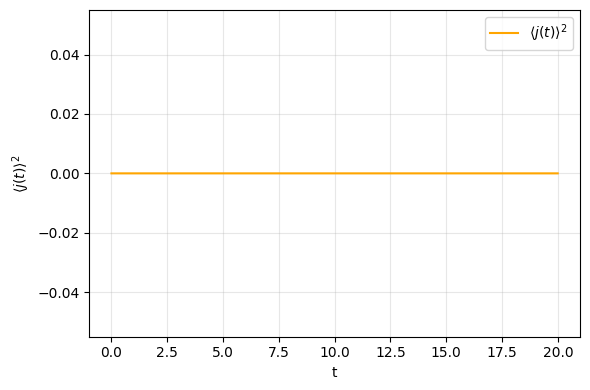

In [ ]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

# Parameters
t1, t2 = 2.0, 1.0
A0 = 0.5
Nc = 10
dt = 0.01
Nk = 200   
Nt = 2000
k_vals = np.linspace(0, pi, Nk//2, endpoint=False)  # only half the BZ

# Vector potential
def A(t):
    return A0 * np.sin(2 * pi * t / Nc)

# Current operator j(k,t)
def j_k(k, t):
    At = A(t)
    num = t2 * sin(At) + t1 * (sin(k) - sin(k - At))
    den = np.sqrt(t1**2 + t2**2 + 2 * t1 * t2 * cos(k))
    return num / den

times = np.arange(0, Nt*dt, dt)
j_mean_sq = np.zeros_like(times)

for i, t in enumerate(times):
    # symmetric pair average: j(k,t) + j(-k,t) = 0
    j_mean = 0.0
    j_mean_sq[i] = j_mean**2   

# Plot <j(t)>^2 
plt.figure(figsize=(6,4))
plt.plot(times, j_mean_sq, label=r'$\langle j(t) \rangle^2$', color="orange")
plt.xlabel("t")
plt.ylabel(r'$\langle j(t) \rangle^2$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
